<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 04 &mdash; Simulated Data**

&copy; Dr. Yves J. Hilpisch

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

## Finance Environment

## Introduction to Simulated Financial Data

This notebook introduces a crucial concept in quantitative finance: **controlled experimentation with simulated data**. While real market data (as in Notebook 3) provides authentic challenges, simulated data allows us to:

### Why Simulate Financial Data?

**1. Controlled Experiments:**
- Test strategies under known conditions
- Isolate specific market behaviors (trends, mean-reversion, volatility)
- Validate algorithms before risking real capital

**2. Research Benefits:**
- Generate unlimited training data
- Create stress-test scenarios
- Study algorithm behavior under different market regimes

**3. Risk Management:**
- Safe environment for algorithm development
- No financial loss during experimentation
- Reproducible results for scientific validation

### Two Approaches in This Notebook:

**1. Noisy Real Data:** Adding controlled noise to actual market data
**2. Simulated Processes:** Generating synthetic price paths using mathematical models

### Key Learning Objectives:
- Understand stochastic process modeling for financial markets
- Learn data augmentation techniques for training robust algorithms
- Compare performance on real vs. simulated data
- Design controlled experiments for algorithmic trading research

In [1]:
class ActionSpace:
    def sample(self):
        return random.randint(0, 1)

In [2]:
import numpy as np
import pandas as pd
from numpy.random import default_rng

In [3]:
rng = default_rng(seed=100)

In [4]:
class NoisyData:
    url = 'https://certificate.tpq.io/findata.csv'
    def __init__(self, symbol, feature, n_features=4,
                 min_accuracy=0.485, noise=True,
                 noise_std=0.001):
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.noise = noise
        self.noise_std = noise_std
        self.action_space = ActionSpace()
        self.min_accuracy = min_accuracy
        self._get_data()
        self._prepare_data()
    def _get_data(self):
        self.raw = pd.read_csv(self.url,
                index_col=0, parse_dates=True)

### Data Augmentation with Controlled Noise

The `NoisyData` class extends our previous `Finance` environment by adding **controlled noise injection**:

**Key Innovation - Noise Parameters:**
- **`noise`**: Boolean flag to enable/disable noise injection
- **`noise_std`**: Standard deviation of noise relative to price level
- **Dynamic regeneration**: Fresh noise patterns for each episode reset

**Purpose of Adding Noise:**
1. **Data Augmentation**: Create variations of the same underlying data
2. **Robustness Testing**: Ensure algorithms work under noisy conditions
3. **Overfitting Prevention**: Reduce memorization of specific price patterns
4. **Reality Simulation**: Markets have microstructure noise and measurement errors

**Mathematical Approach:**
- Noise magnitude scales with price level: `std = price_mean * noise_std`
- Gaussian noise: `price_noisy = price_original + N(0, std)`
- Preserves overall price structure while adding realistic variation

In [5]:
class NoisyData(NoisyData):
    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol]).dropna()
        if self.noise:
            std = self.data.mean() * self.noise_std
            self.data[self.symbol] = (self.data[self.symbol] +
                rng.normal(0, std, len(self.data)))
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data.dropna(inplace=True)
        ma, mi = self.data.max(), self.data.min()
        self.data_ = (self.data - mi) / (ma - mi)
    def reset(self):
        if self.noise:
            self._prepare_data()
        self.bar = self.n_features
        self.treward = 0
        state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return state, {}

### Enhanced Data Preparation Pipeline

**Key Improvements in `_prepare_data()`:**

**1. Conditional Noise Injection:**
```python
if self.noise:
    std = self.data.mean() * self.noise_std
    self.data[self.symbol] = (self.data[self.symbol] + 
                              rng.normal(0, std, len(self.data)))
```

**2. Improved Normalization:**
- **Min-Max Scaling**: `(data - min) / (max - min)` 
- **Range [0,1]**: Better for neural network stability
- **Preserves relative relationships**: Unlike z-score normalization

**3. Dynamic Reset Capability:**
- **Fresh noise per episode**: `if self.noise: self._prepare_data()`
- **Prevents overfitting**: Each episode sees slightly different data
- **Maintains base patterns**: Core market structure preserved

In [6]:
class NoisyData(NoisyData):
    def step(self, action):
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        reward = 1 if correct else 0 
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.n_features + 15):
            done = True
        else:
            done = False
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return next_state, reward, done, False, {}

In [7]:
fin = NoisyData(symbol='EUR=', feature='EUR=',
                noise=True, noise_std=0.005)

### Testing Data Augmentation

**Configuration:**
- **Symbol**: EUR/USD exchange rate
- **Feature**: Price levels (not returns)
- **Noise enabled**: True with 0.5% standard deviation
- **Effect**: Each reset generates slightly different price series

**Observing Noise Impact:**
Running `reset()` multiple times shows how the same underlying data gets different noise realizations, creating variety for training while preserving fundamental patterns.

In [8]:
fin.reset()

(array([0.79295659, 0.81097879, 0.78840972, 0.80597193]), {})

In [9]:
fin.reset()

(array([0.80642276, 0.77840938, 0.80096369, 0.76938581]), {})

In [10]:
fin = NoisyData('EUR=', 'r', n_features=4,
                noise=True, noise_std=0.005)

In [11]:
fin.reset()

(array([0.54198375, 0.30674865, 0.45688528, 0.52884033]), {})

In [12]:
fin.reset()

(array([0.37967631, 0.40190291, 0.49196183, 0.47536065]), {})

In [13]:
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [14]:
import warnings
warnings.simplefilter('ignore')

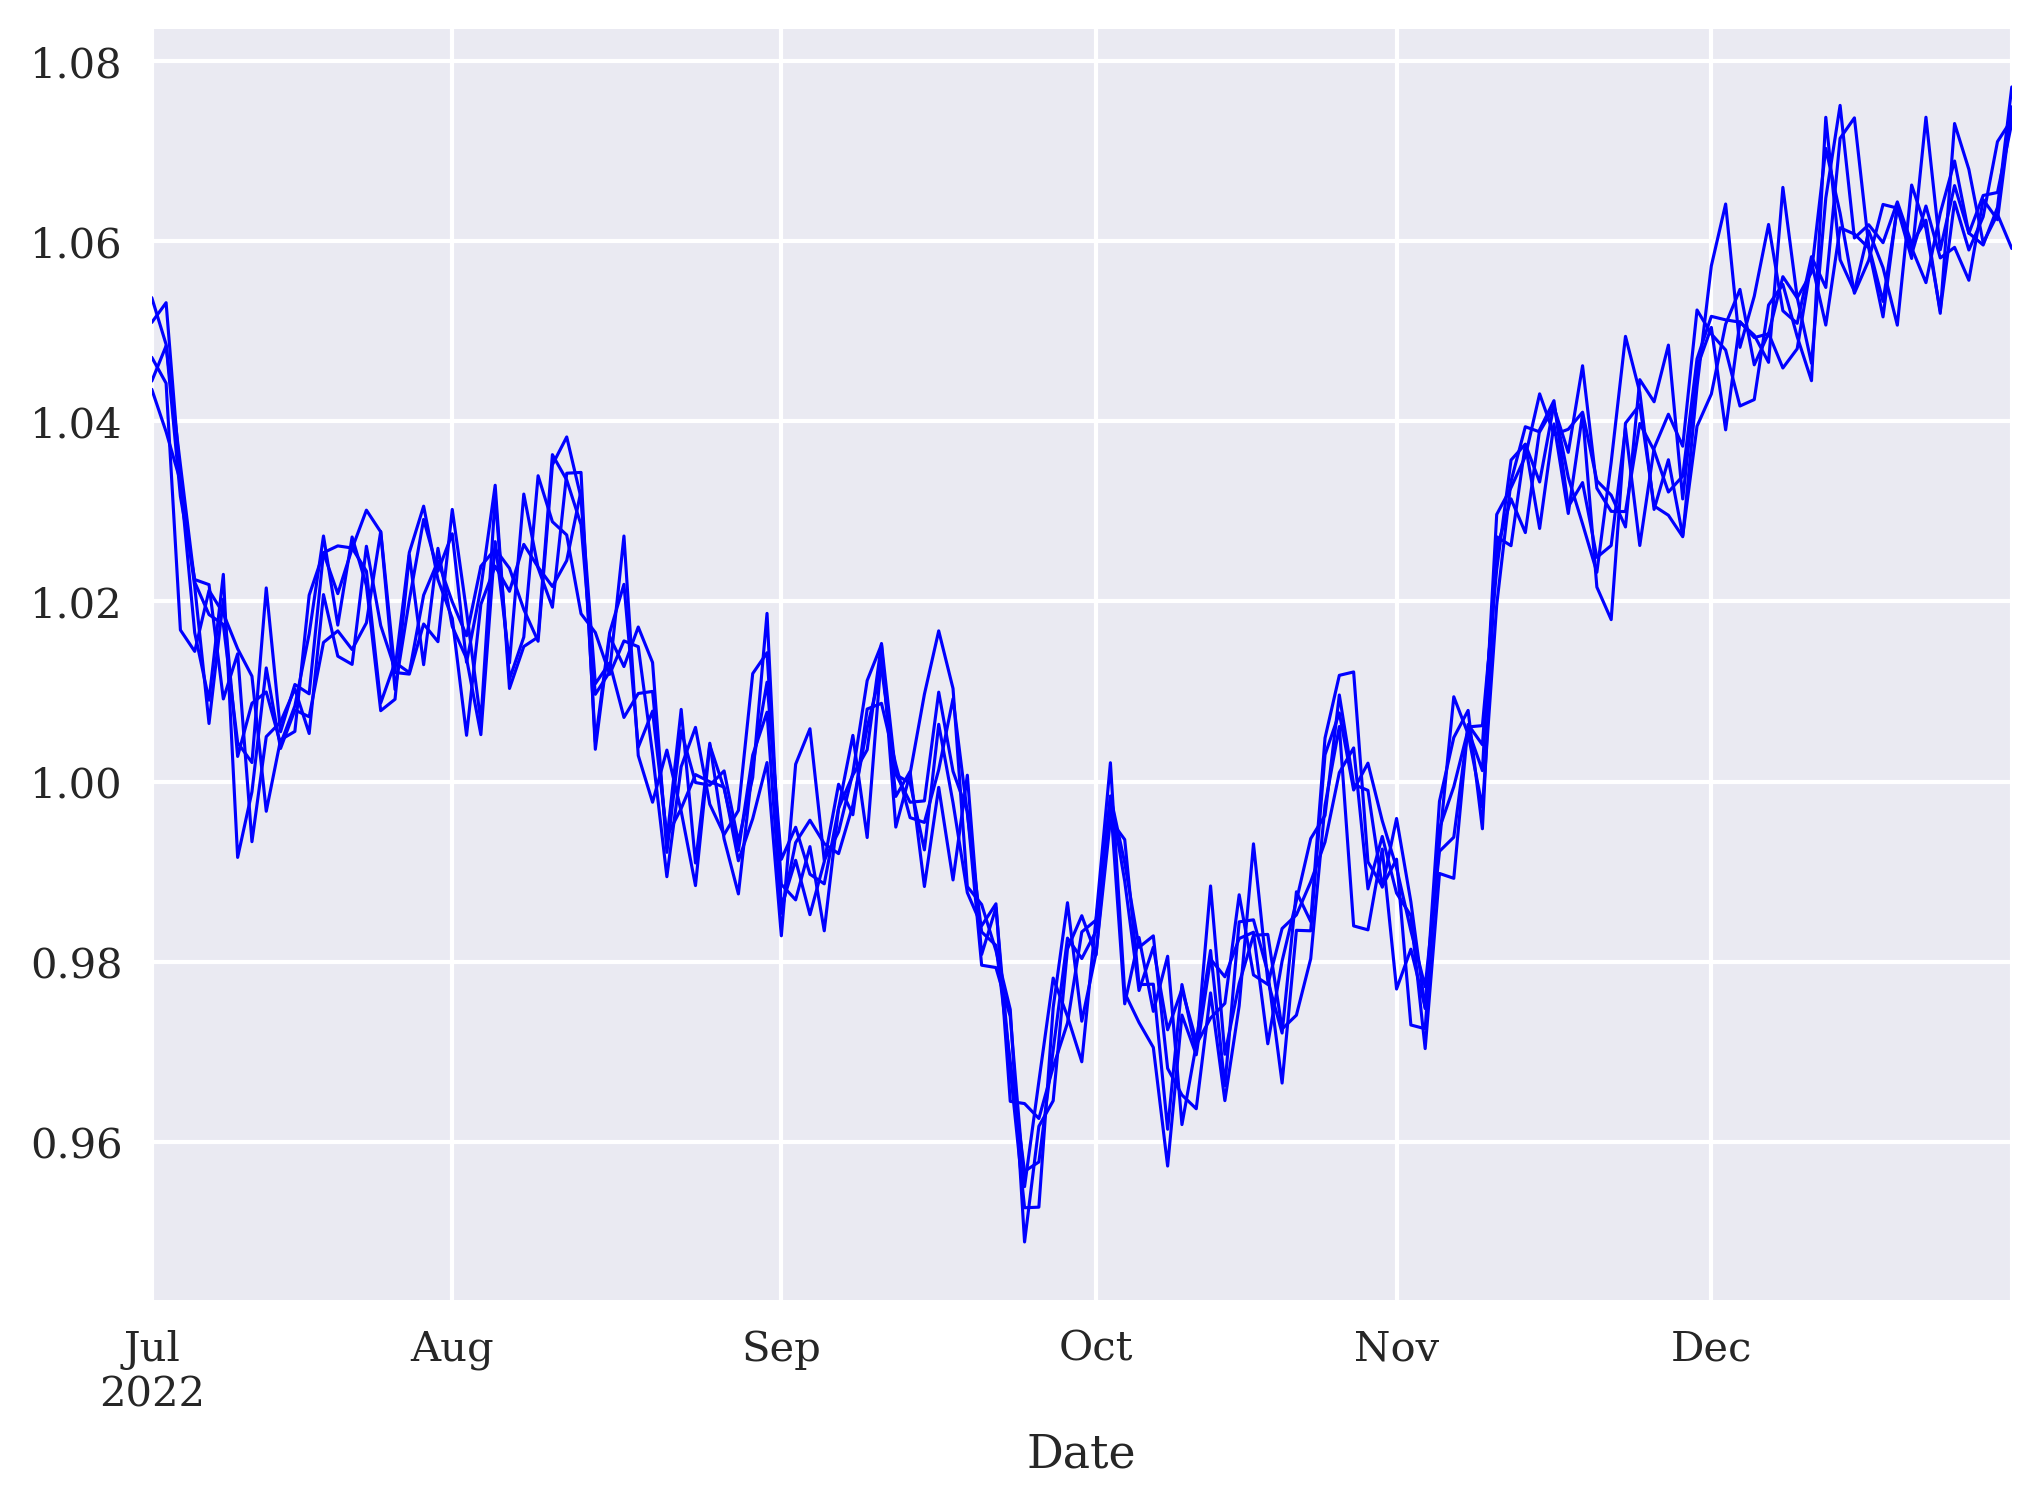

In [15]:
for _ in range(5):
    fin.reset()
    fin.data[fin.symbol].loc['2022-7-1':].plot(lw=0.75, c='b')

### Visualizing Noise Effects

**Plotting Multiple Realizations:**
This visualization shows 5 different noise realizations of the same underlying EUR/USD data from July 2022 onward. Notice how:

- **Base pattern preserved**: Overall trends and major movements remain
- **Variation introduced**: Each line differs slightly due to noise
- **Realistic appearance**: Noise creates natural-looking price variations
- **Training diversity**: Algorithm sees multiple versions of the same data

This technique is similar to data augmentation in computer vision, where images are rotated or cropped to create training variety.

In [16]:
%run dqlagent.py

In [17]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [18]:
agent = DQLAgent(fin.symbol, fin.feature, fin.n_features, fin)

### Training on Augmented Data

**Using External DQL Agent:**
- **`%run dqlagent.py`**: Loads a more sophisticated DQL implementation
- **Environment integration**: Agent designed to work with our custom environments
- **Noise adaptation**: Algorithm must learn robust patterns despite data variation

**Expected Benefits:**
- **Better generalization**: Less overfitting to specific price sequences
- **Improved robustness**: Handles real market noise better
- **Enhanced learning**: More diverse training experiences

In [19]:
%time agent.learn(250)

episode= 250 | treward=  8.000 | max=1477.0000
CPU times: user 37.6 s, sys: 6.01 s, total: 43.6 s
Wall time: 37.9 s


In [20]:
agent.test(5)

total reward=2604 | accuracy=0.591
total reward=2604 | accuracy=0.605
total reward=2604 | accuracy=0.614
total reward=2604 | accuracy=0.594
total reward=2604 | accuracy=0.616



In [21]:
class Simulation:
    def __init__(self, symbol, feature, n_features,
                 start, end, periods,
                 min_accuracy=0.525, x0=100,
                 kappa=1, theta=100, sigma=0.2,
                 normalize=True, new=False):
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.start = start
        self.end = end
        self.periods = periods
        self.x0 = x0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.min_accuracy = min_accuracy
        self.normalize = normalize
        self.new = new
        self.action_space = ActionSpace()
        self._simulate_data()
        self._prepare_data()

## Stochastic Process Simulation

**Moving Beyond Real Data to Mathematical Models:**

The `Simulation` class implements **stochastic differential equation (SDE) models** for generating synthetic financial data. This represents a major advancement in quantitative finance research.

### Ornstein-Uhlenbeck Process Parameters:

**Mathematical Model:**
```
dX(t) = κ(θ - X(t))dt + σX(t)dW(t)
```

**Parameter Interpretation:**
- **`x0`**: Initial price level
- **`kappa (κ)`**: Mean reversion speed (higher = faster return to mean)
- **`theta (θ)`**: Long-term mean level (price gravitates toward this)
- **`sigma (σ)`**: Volatility parameter (price randomness)

**Financial Intuition:**
- **κ > 1**: Strong mean reversion (good for range-bound markets)
- **θ ≠ x0**: Creates trends (price moves toward θ)
- **σ**: Controls how noisy the price path is
- **Time discretization**: Daily steps with appropriate scaling

In [22]:
import math
class Simulation(Simulation):
    def _simulate_data(self):
        index = pd.date_range(start=self.start,
                    end=self.end, periods=self.periods)
        x = [self.x0]
        dt = (index[-1] - index[0]).days / 365 / self.periods
        for t in range(1, len(index)):
            x_ = (x[t - 1] + self.kappa * (self.theta - x[t - 1]) * dt +
                  x[t - 1] * self.sigma * math.sqrt(dt) *
                  random.gauss(0, 1))
            x.append(x_)
        
        self.data = pd.DataFrame(x, columns=[self.symbol], index=index)

### Implementation of Stochastic Process

**`_simulate_data()` Method Breakdown:**

**1. Time Grid Construction:**
- **`pd.date_range()`**: Creates realistic time index
- **`dt = days/365/periods`**: Proper time scaling for continuous models

**2. Euler-Maruyama Discretization:**
```python
x[t] = x[t-1] + κ(θ - x[t-1])dt + σx[t-1]√dt * N(0,1)
```
- **Drift term**: `κ(θ - x[t-1])dt` pulls price toward mean
- **Diffusion term**: `σx[t-1]√dt * N(0,1)` adds random variation
- **Geometric component**: Volatility scales with price level

**3. Financial Realism:**
- **Path dependency**: Each price depends on previous price
- **Controlled randomness**: Parameters determine market behavior
- **Realistic time structure**: Proper business day scaling

In [23]:
class Simulation(Simulation):
    def _prepare_data(self):
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        if self.normalize:
            self.mu = self.data.mean()
            self.std = self.data.std()
            self.data_ = (self.data - self.mu) / self.std
        else:
            self.data_ = self.data.copy()
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data['d'] = self.data['d'].astype(int)

In [24]:
class Simulation(Simulation):
    def _get_state(self):
        return self.data_[self.feature].iloc[self.bar -
                                self.n_features:self.bar]
    def seed(self, seed):
        random.seed(seed)
        tf.random.set_seed(seed)
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.bar = self.n_features
        if self.new:
            self._simulate_data()
            self._prepare_data()
        state = self._get_state()
        return state.values, {}

### Advanced Simulation Control

**Enhanced Environment Features:**

**1. Fresh Data Generation (`new=True`):**
- **Dynamic simulation**: New price path for each episode reset
- **Unlimited data**: Never run out of training examples
- **Scenario testing**: Easy to test different market conditions

**2. Reproducible Experiments:**
- **`seed()` method**: Ensures consistent results across runs
- **Scientific rigor**: Critical for research and backtesting
- **TensorFlow integration**: Controls both numpy and TF random states

**3. Flexible State Management:**
- **`_get_state()`**: Clean interface for state extraction
- **Configurable lookback**: Easy to change historical window
- **Normalized states**: Ready for neural network input

In [25]:
class Simulation(Simulation):
    def step(self, action):
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        reward = 1 if correct else 0 
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and self.bar > 25):
            done = True
        else:
            done = False
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return next_state, reward, done, False, {}

In [26]:
sym = 'EUR='

In [27]:
env_base = Simulation(sym, sym, 5, start='2024-1-1', end='2025-1-1',
                 periods=252, x0=1, kappa=1, theta=1.1, sigma=0.0,
                 normalize=True)
env_base.seed(100)

In [28]:
env_trend = Simulation(sym, sym, 5, start='2024-1-1', end='2025-1-1',
                 periods=252, x0=1, kappa=1, theta=2, sigma=0.1,
                 normalize=True)
env_trend.seed(100)

### Designing Different Market Regimes

**Three Distinct Market Behaviors:**

**1. Baseline Environment (`env_base`):**
- **No trend**: `x0=1, theta=1.1` (minimal drift)
- **No volatility**: `sigma=0.0` (deterministic path)
- **Pure mean reversion**: Prices oscillate around mean

**2. Trending Environment (`env_trend`):**
- **Strong upward trend**: `theta=2` (twice the starting price)
- **Moderate volatility**: `sigma=0.1` (some randomness)
- **Momentum behavior**: Prices generally move upward

**3. Mean-Reverting Environment (`env_mrev`):**
- **Strong reversion**: `theta=1` (same as starting point)
- **Moderate volatility**: `sigma=0.1` (realistic noise)
- **Range-bound**: Prices oscillate around starting level

**Research Value:**
These controlled experiments let us test how algorithms perform under known market conditions - crucial for understanding strategy strengths and weaknesses.

In [29]:
env_mrev = Simulation(sym, sym, 5, start='2024-1-1', end='2025-1-1',
                 periods=252, x0=1, kappa=1, theta=1, sigma=0.1,
                 normalize=True)
env_mrev.seed(100)

In [30]:
env_mrev.data[sym].iloc[:3]

2024-01-02 10:59:45.657370517    1.004236
2024-01-03 21:59:31.314741035    1.009752
2024-01-05 08:59:16.972111553    1.011010
Name: EUR=, dtype: float64

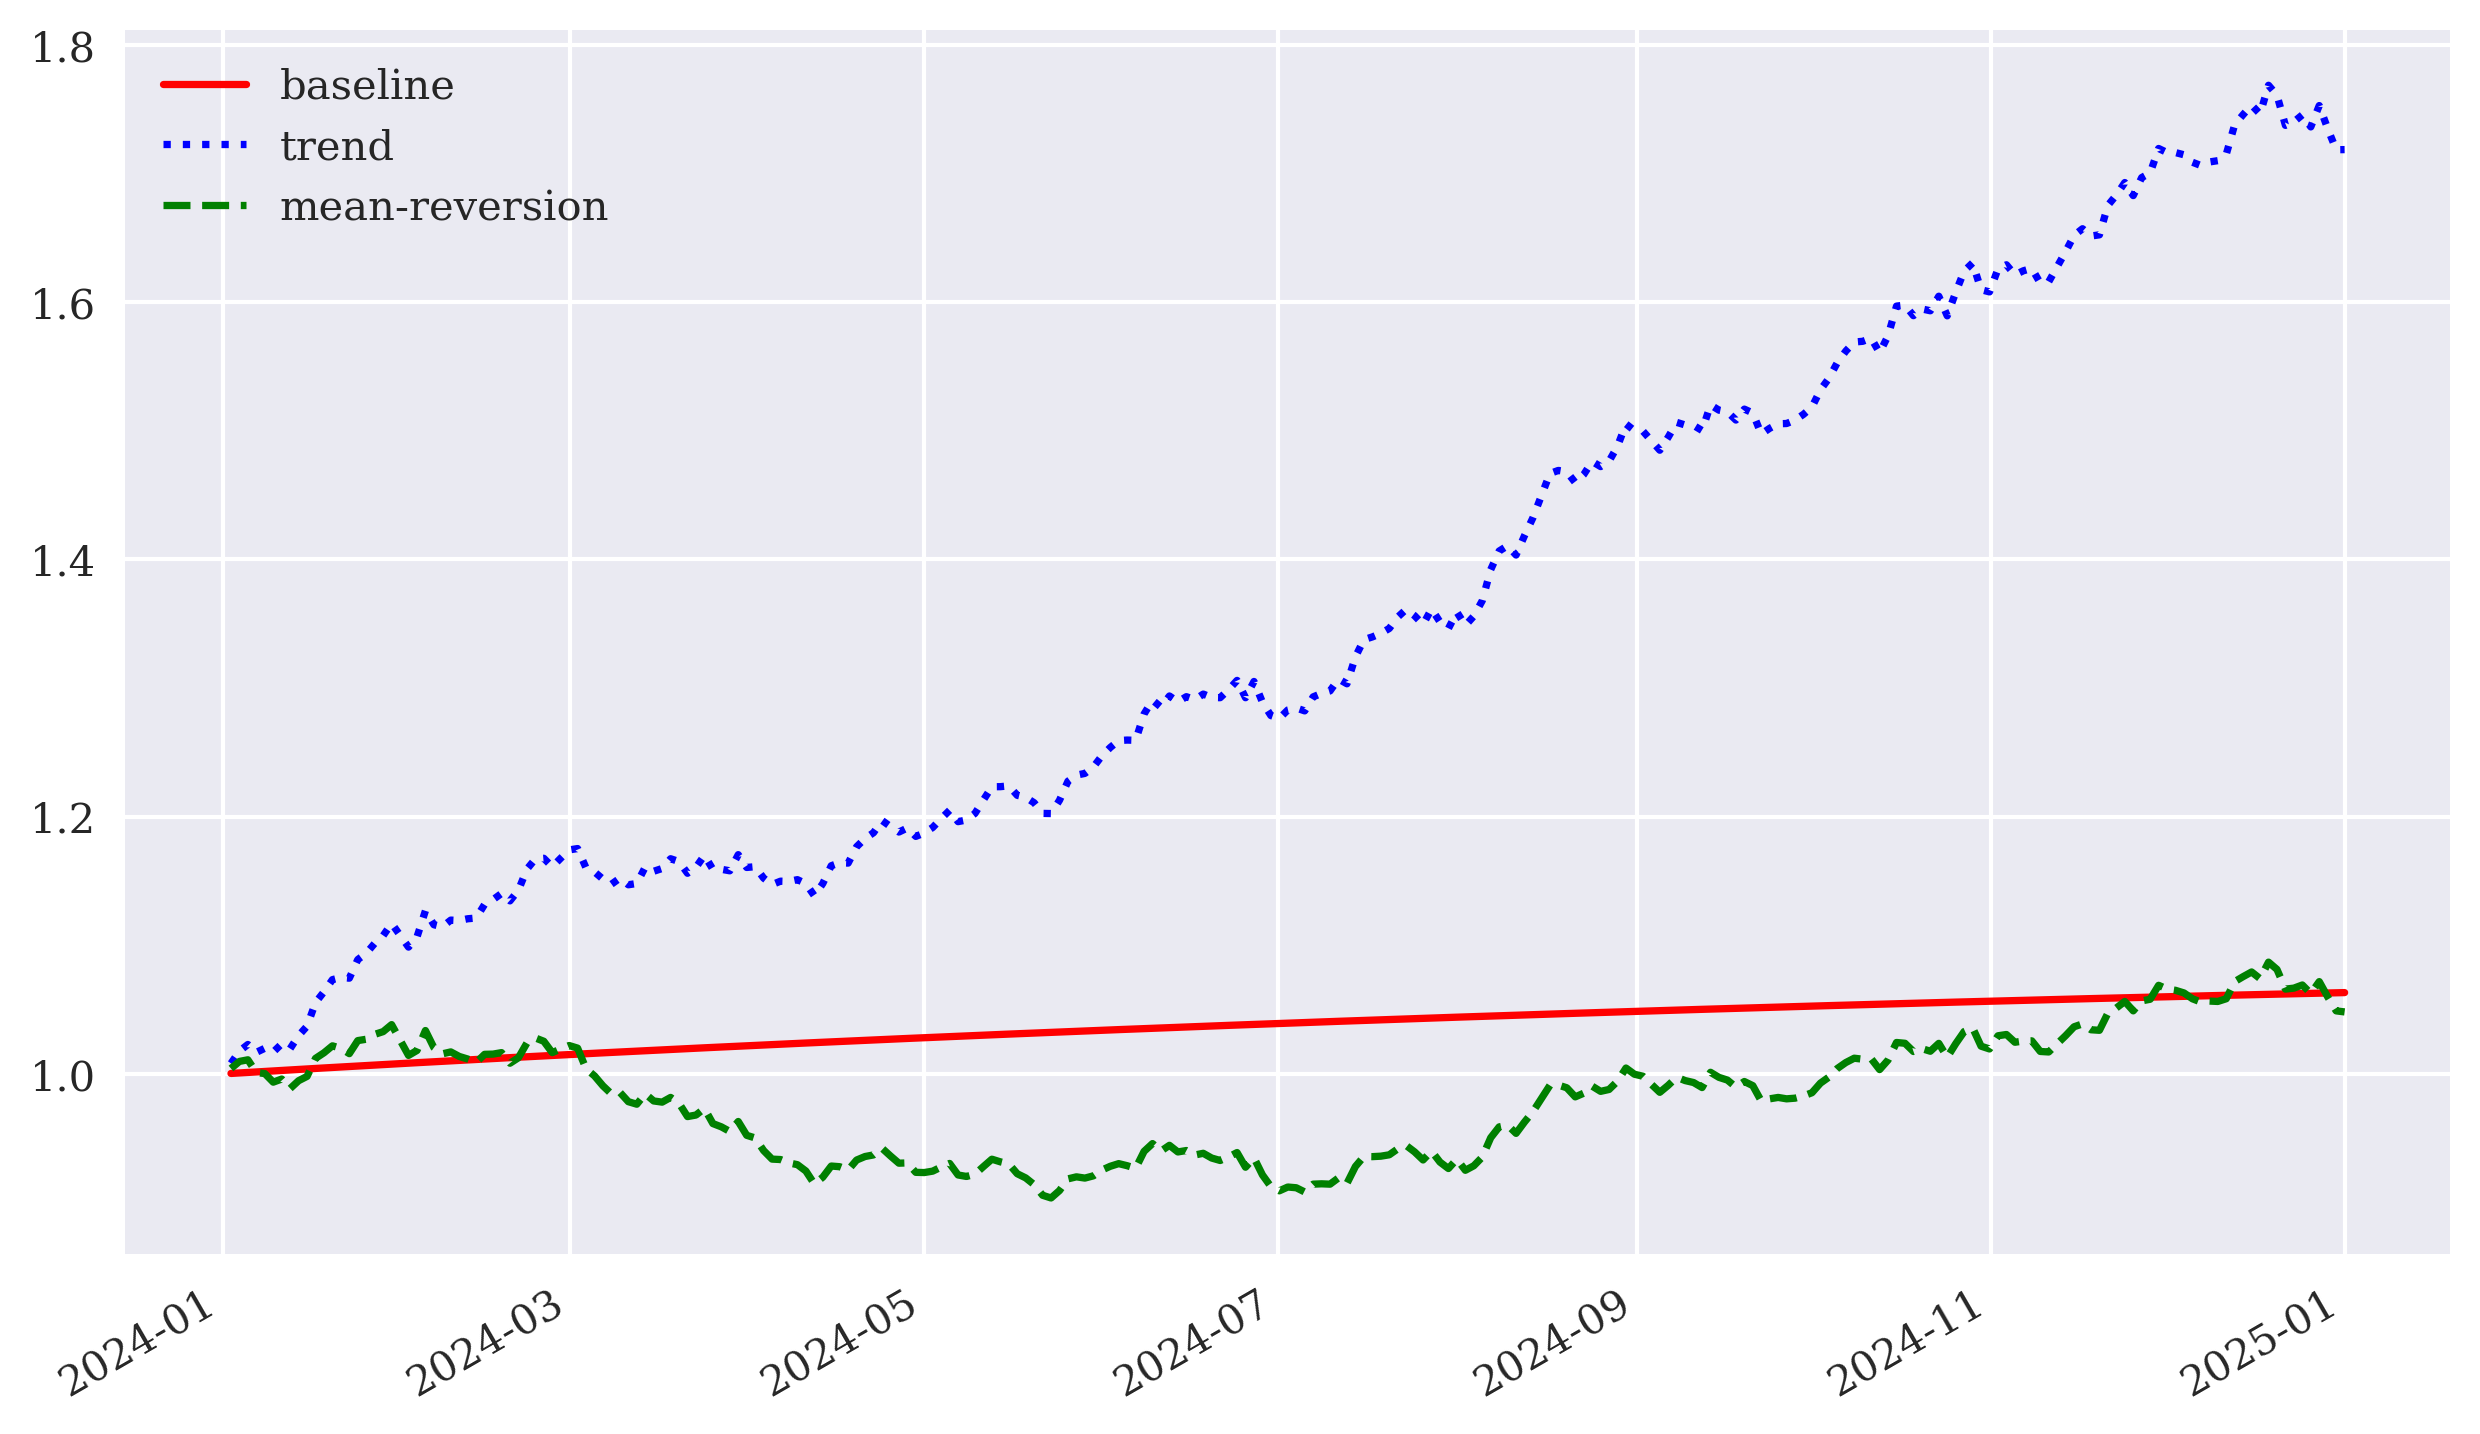

In [31]:
env_base.data[sym].plot(figsize=(10, 6), label='baseline', style='r')
env_trend.data[sym].plot(label='trend', style='b:')
env_mrev.data[sym].plot(label='mean-reversion', style='g--')
plt.legend();

**Visualizing Market Regimes:**

This plot clearly shows the three different market behaviors:
- **Red (Baseline)**: Slight upward drift with no volatility
- **Blue (Trend)**: Strong upward movement with moderate noise  
- **Green (Mean-Reversion)**: Oscillation around starting level

**Strategic Implications:**
- **Trend-following algorithms**: Should excel in blue environment
- **Mean-reversion strategies**: Should perform best in green environment
- **Adaptive algorithms**: Should detect and adjust to each regime

In [32]:
sim = Simulation(sym, 'r', 4, start='2024-1-1', end='2028-1-1',
                 periods=2 * 252, min_accuracy=0.485, x0=1,
                 kappa=2, theta=2, sigma=0.15,
                 normalize=True, new=True)
sim.seed(100)

### Dynamic Simulation for Training

**Advanced Configuration (`new=True`):**
- **Extended timeframe**: 2 years of data (2×252 = 504 trading days)
- **Returns-based states**: Using 'r' feature for better stationarity
- **Dynamic regeneration**: New price paths for each episode
- **Realistic parameters**: Balanced trend/reversion with moderate volatility

**Training Benefits:**
- **Infinite data**: Never repeat the same market scenario
- **Diverse experience**: Algorithm sees many different market conditions
- **Robust learning**: Prevents overfitting to specific price patterns
- **Real-world preparation**: Trains for unseen market conditions

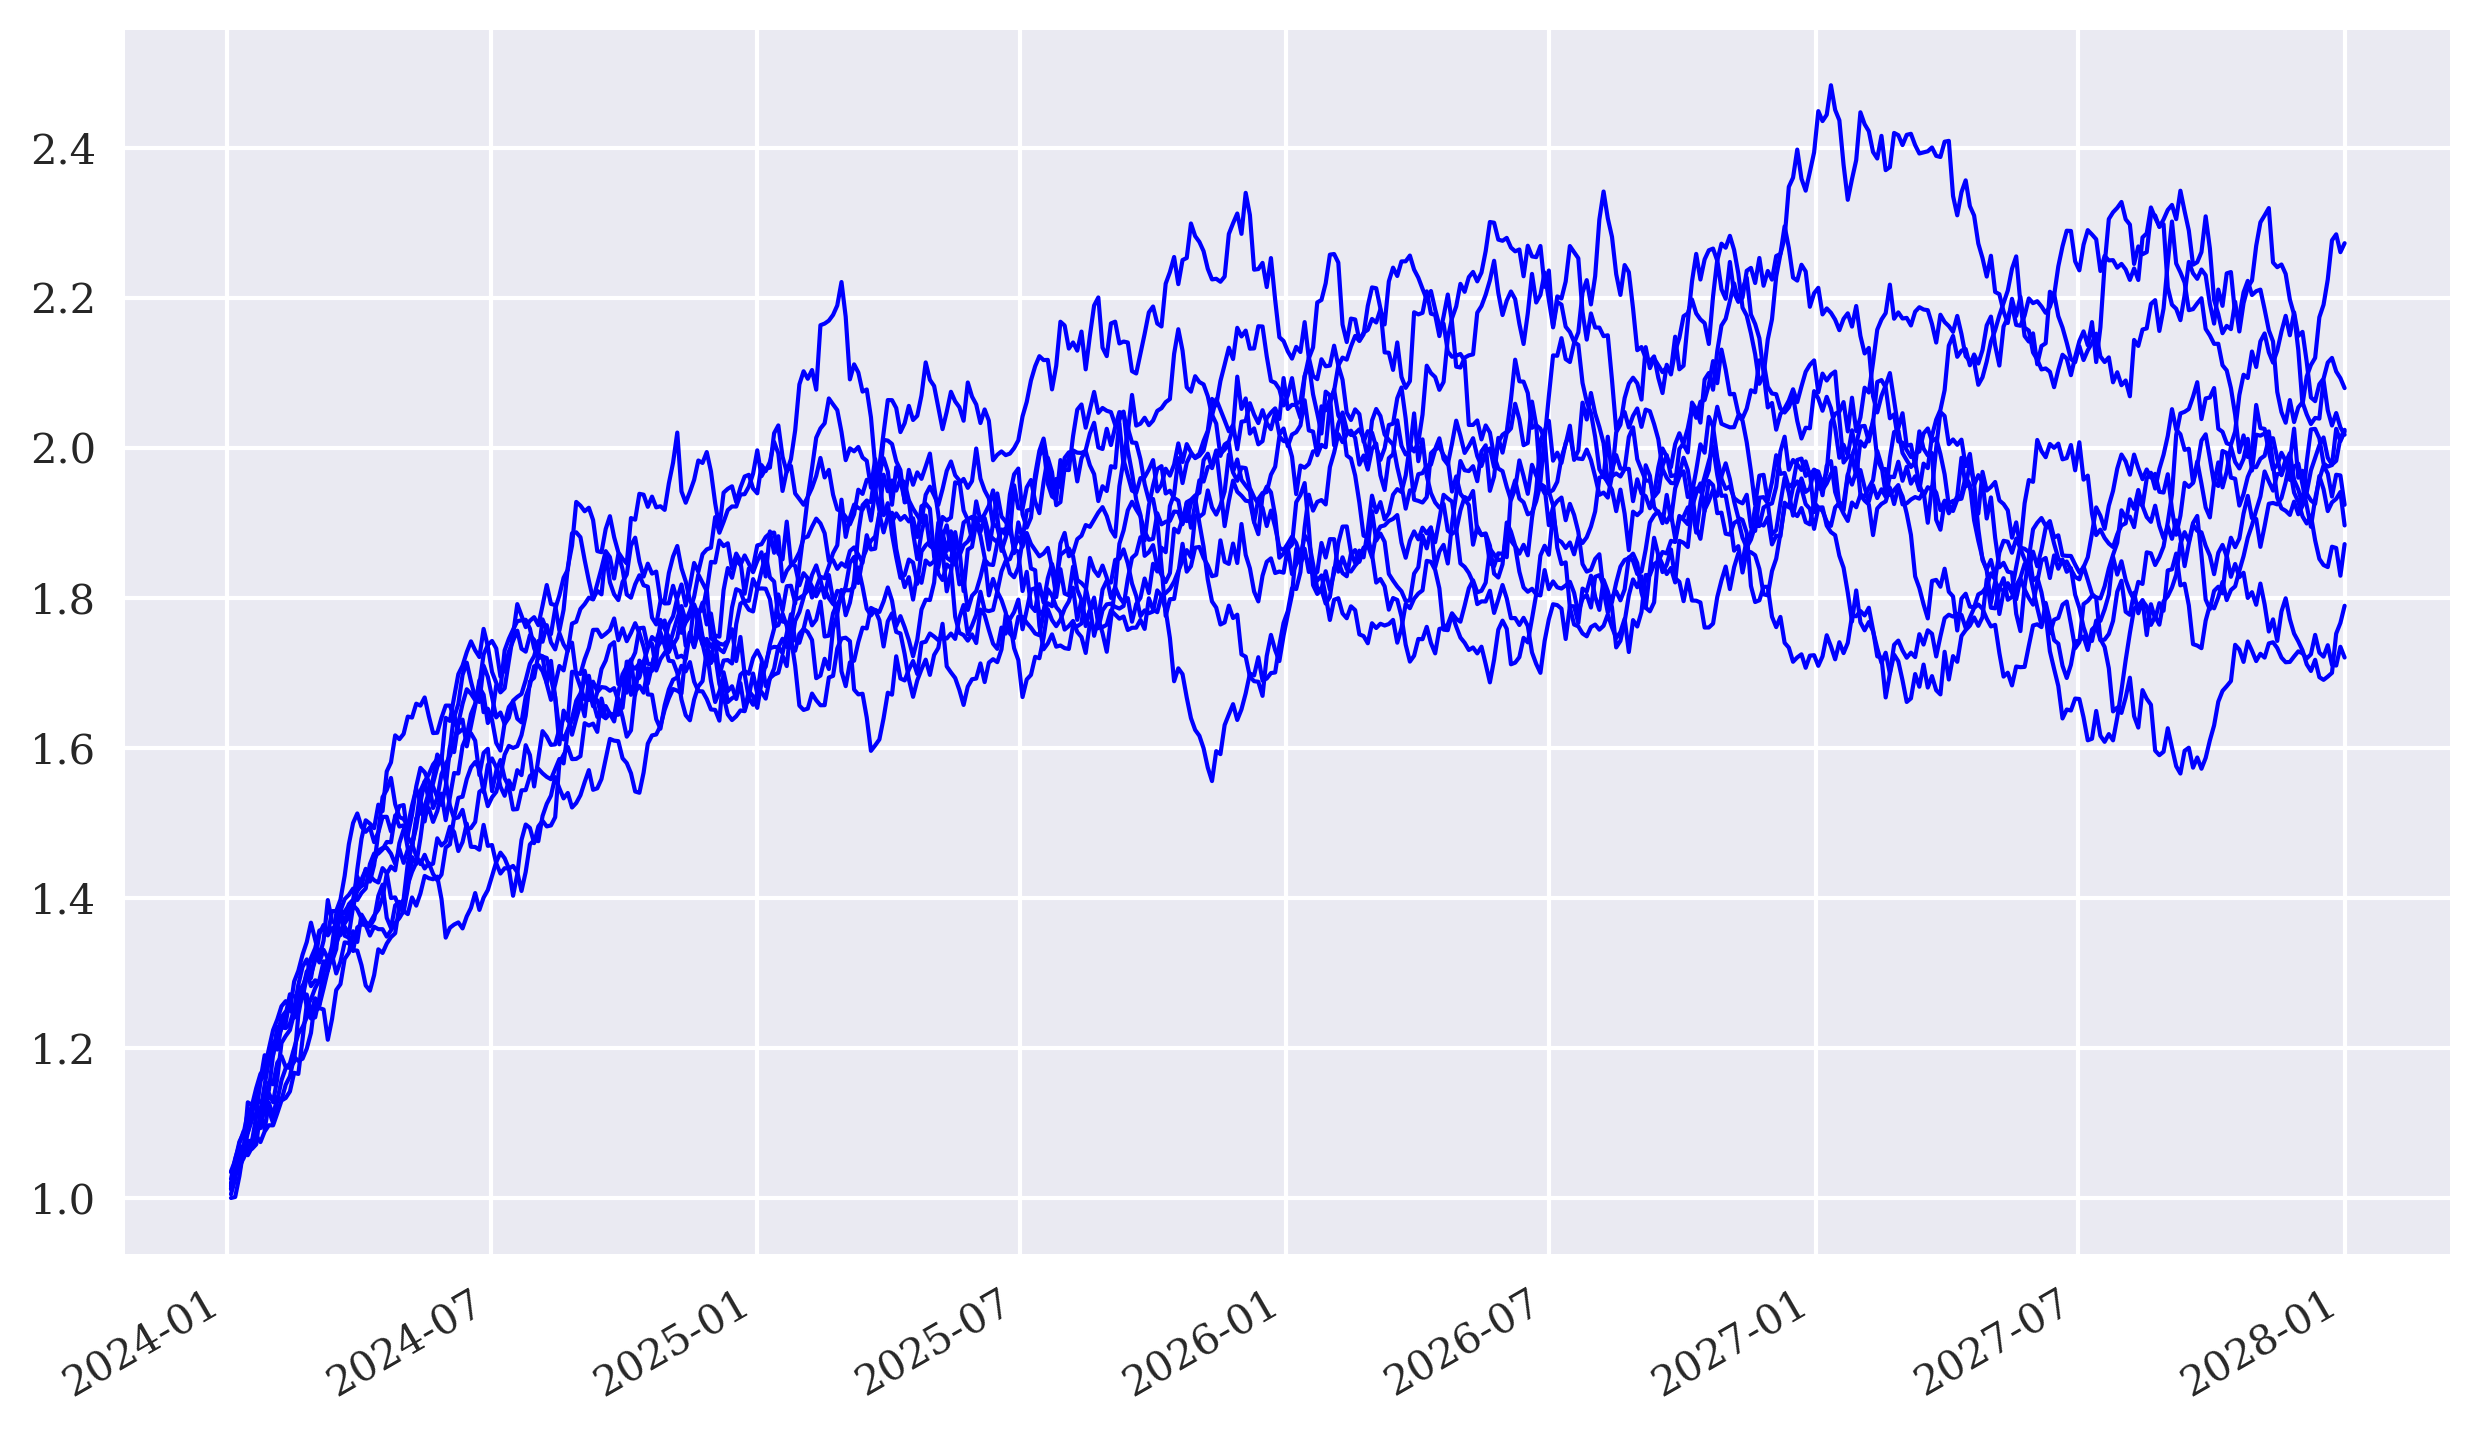

In [33]:
for _ in range(10):
    sim.reset()
    sim.data[sym].plot(figsize=(10, 6), lw=1.0, c='b');

**Visualizing Dynamic Simulations:**

Each of these 10 blue lines represents a completely different market scenario generated by our stochastic process. Notice:
- **Variety in patterns**: Some trending, some mean-reverting, some volatile
- **Realistic appearance**: Paths look like actual financial time series
- **Training diversity**: Algorithm will see this variety during learning
- **Unlimited scenarios**: Can generate thousands of unique market conditions

This is the power of simulation-based training - the algorithm experiences many lifetimes of market conditions in a single training session.

In [34]:
agent = DQLAgent(sim.symbol, sim.feature,
                 sim.n_features, sim, lr=0.0001)

### Training on Pure Simulation

**Extended Training (500 episodes):**
- **More episodes**: Longer training to handle increased complexity
- **Dynamic data**: Each episode uses completely new market data
- **Learning rate**: Fine-tuned for simulated environment
- **Performance goal**: Develop robust strategies across market regimes

**Expected Outcomes:**
- **Slower initial progress**: More complex learning environment
- **Better generalization**: Strategies work across different market conditions
- **Robust performance**: Less sensitive to specific market patterns

In [35]:
%time agent.learn(500)

episode= 500 | treward= 11.000 | max=286.000
CPU times: user 57.9 s, sys: 9.61 s, total: 1min 7s
Wall time: 57.5 s


In [36]:
agent.test(5)

total reward= 499 | accuracy=0.525
total reward= 499 | accuracy=0.543
total reward= 499 | accuracy=0.527
total reward= 499 | accuracy=0.541
total reward= 499 | accuracy=0.531



In [37]:
sim = Simulation(sym, 'r', 4, start='2024-1-1', end='2028-1-1',
                 periods=2 * 252, min_accuracy=0.6, x0=1,
                 kappa=1.25, theta=1, sigma=0.15,
                 normalize=True, new=True)
sim.seed(100)

### Testing Under Challenging Conditions

**Stress Test Configuration:**
- **Higher accuracy threshold**: `min_accuracy=0.6` (60% vs. previous 48.5%)
- **Mean-reverting market**: `kappa=1.25, theta=1` (strong reversion to starting level)
- **Moderate volatility**: `sigma=0.15` (realistic but challenging noise)

**Purpose of Stress Testing:**
- **Performance validation**: Can algorithm handle tough requirements?
- **Market regime adaptation**: Does it work in range-bound conditions?
- **Risk assessment**: How does performance degrade under pressure?

**Real-World Relevance:**
This simulates high-frequency trading or market-making environments where 60%+ accuracy is needed for profitability after transaction costs.

In [38]:
agent = DQLAgent(sim.symbol, sim.feature,
                 sim.n_features, sim, lr=0.0001)

In [39]:
%time agent.learn(500)

episode= 500 | treward=  6.000 | max= 84.000
CPU times: user 27.2 s, sys: 4.63 s, total: 31.9 s
Wall time: 26.8 s


In [40]:
agent.test(5)

total reward= 499 | accuracy=0.487
total reward= 499 | accuracy=0.499
total reward= 499 | accuracy=0.477
total reward= 499 | accuracy=0.499
total reward= 499 | accuracy=0.501



<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

## Summary: Mastering Controlled Experimentation

This notebook introduced sophisticated techniques for **controlled financial experimentation** - a crucial bridge between theoretical research and practical trading:

### Key Technical Innovations:

**1. Data Augmentation:**
- **Noise injection**: Adding realistic variations to historical data
- **Dynamic regeneration**: Fresh data patterns for each training episode
- **Overfitting prevention**: Reducing memorization of specific market patterns

**2. Stochastic Process Modeling:**
- **Ornstein-Uhlenbeck processes**: Mathematical foundation for price simulation
- **Parameter control**: Precise manipulation of trend, mean-reversion, and volatility
- **Infinite data generation**: Never-ending supply of training scenarios

**3. Market Regime Testing:**
- **Baseline scenarios**: Controlled environments for isolated testing
- **Trending markets**: Momentum-driven price behavior
- **Mean-reverting markets**: Range-bound, oscillating price action
- **Stress testing**: High-performance requirements under challenging conditions

### Research and Development Benefits:

**1. Scientific Rigor:**
- **Reproducible experiments**: Controlled conditions for valid comparisons
- **Hypothesis testing**: Isolated variables for clear cause-effect relationships
- **Performance attribution**: Understanding why strategies work or fail

**2. Risk Management:**
- **Safe development**: No financial risk during algorithm development
- **Scenario planning**: Testing under extreme market conditions
- **Robustness validation**: Ensuring strategies work across different environments

**3. Strategy Development:**
- **Rapid iteration**: Quick testing of new ideas
- **Parameter optimization**: Systematic tuning under controlled conditions
- **Performance benchmarking**: Fair comparison across different approaches

### Real-World Applications:

**1. Quantitative Finance:**
- **Strategy backtesting**: Validation before live trading
- **Risk model development**: Stress testing portfolio strategies
- **Algorithm optimization**: Parameter tuning under controlled conditions

**2. Academic Research:**
- **Publication-quality experiments**: Reproducible, controlled studies
- **Theoretical validation**: Testing mathematical models empirically
- **Comparative analysis**: Fair evaluation of competing approaches

**3. Commercial Development:**
- **Product testing**: Validating trading algorithms before client deployment
- **Regulatory compliance**: Demonstrating strategy robustness to regulators
- **Due diligence**: Systematic evaluation of investment strategies

### The Learning Journey So Far:

- **Notebook 1**: Basic learning concepts with simple examples
- **Notebook 2**: Deep Q-Learning with game environments (CartPole)  
- **Notebook 3**: Real market data application (EUR/USD prediction)
- **Notebook 4**: Controlled experimentation with simulated data

### Next Frontier:
This simulation foundation enables:
- **Multi-asset strategies**: Portfolio optimization across instruments
- **Options and derivatives**: Complex payoff structures
- **High-frequency trading**: Microsecond decision-making
- **Market impact modeling**: How trades affect prices
- **Regime detection**: Automatically adapting to changing market conditions

**The Power of Simulation:**
We've learned that simulation isn't just about generating fake data - it's about creating **controlled laboratories** where we can systematically study, test, and improve financial algorithms under known conditions. This is essential for developing robust, profitable trading strategies that work in the real world.

The combination of real data (for authenticity) and simulated data (for control) provides the complete toolkit for serious quantitative finance research and development.